In [ ]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        #rhomat = torch.einsum('iijj->jj', reshaped_transposed_Q)
        # Trace out the first two dimensions
        rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        for i in range(reshaped_transposed_Q.shape[0]):
            for j in range(reshaped_transposed_Q.shape[1]):
                rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [2] * total_size)  # Partial trace over B

    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(total_size//2)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

# Define the linear combination function
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

In [3]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
"""# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,2,8]  # triangular plaquette
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
print(f"Traced out density matrix: {traced_out_density_matrix_dense}")
print(f"Traced out density matrix: {traced_out_density_matrix}")

# Diagonalize the traced out density matrix
to_eigenvalues, to_eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {to_eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(to_eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")"""

'# ground state of H only + debugging partial trace\n\n# Compute smallest eigenvalue and the corresponding eigenvector\nmin_eigenvalue, min_eigenvector = eigsh(H, k=1, which=\'SA\')\n\nprint(f"Minimum eigenvalue: {min_eigenvalue}")\nprint(f"Corresponding eigenvector shape: {min_eigenvector.shape}")\n#print(f"Corresponding eigenvector: {min_eigenvector}")\n\n#Construct the density matrix\ndensity_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n\nprint(f"Density matrix shape: {density_matrix.shape}")\n#print(f"Density matrix: {density_matrix}")\n\ndensity_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\nprint(f"qobj density matrix shape: {density_matrix_qobj.shape}")\n#print(f"qobj density matrix: {density_matrix_qobj}")\n\n# Trace out some qubits (keep other qubits)\nkeep_qubits = [0,2,8]  # triangular plaquette\ntraced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n# Convert the result back to a dense matrix if needed\ntraced_out_density_matrix_den

In [5]:
"""# ground state of H only + debugging partial trace - no qutip

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,2,8]  # triangular plaquette
traced_out_density_matrix = partial_trace_qubit(density_matrix, keep_qubits, [2]*N)

print(type(traced_out_density_matrix))

print(f"Traced out density matrix shape: {traced_out_density_matrix.shape}")
print(f"Traced out density matrix: {traced_out_density_matrix}")

# Diagonalize the traced out density matrix
to_eigenvalues, to_eigenvectors = np.linalg.eigh(traced_out_density_matrix)
#print(f"Eigenvalues of the traced out density matrix: {to_eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(to_eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")"""

'# ground state of H only + debugging partial trace - no qutip\n\n# Compute smallest eigenvalue and the corresponding eigenvector\nmin_eigenvalue, min_eigenvector = eigsh(H, k=1, which=\'SA\')\n\nprint(f"Minimum eigenvalue: {min_eigenvalue}")\nprint(f"Corresponding eigenvector shape: {min_eigenvector.shape}")\n#print(f"Corresponding eigenvector: {min_eigenvector}")\n\n#Construct the density matrix\ndensity_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n\nprint(f"Density matrix shape: {density_matrix.shape}")\n#print(f"Density matrix: {density_matrix}")\n\n# Trace out some qubits (keep other qubits)\nkeep_qubits = [0,2,8]  # triangular plaquette\ntraced_out_density_matrix = partial_trace_qubit(density_matrix, keep_qubits, [2]*N)\n\nprint(type(traced_out_density_matrix))\n\nprint(f"Traced out density matrix shape: {traced_out_density_matrix.shape}")\nprint(f"Traced out density matrix: {traced_out_density_matrix}")\n\n# Diagonalize the traced out density matrix\nto_eigenvalue

In [6]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [7]:
'''#debugging, checking 3 spins rdm + comparison to paper

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    keep_qubits = [0, 2, 8]  # triangular plaquette
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced),
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))'''

'#debugging, checking 3 spins rdm + comparison to paper\n\nmin_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    keep_qubits = [0, 2, 8]  # triangular plaquette\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n\n    # Print the rank of the traced out density matrix\n    rank = np.linalg.matrix_rank(traced_out_density_matrix)\n    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")\n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eige

In [8]:
'''# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H

min_eigenvalues = np.array(min_eigenvalues)

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, min_eigenvalues, s=1)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#lt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()'''

'# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\n\nmin_eigenvalues = np.array(min_eigenvalues)\n\n# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\nplt.scatter(eigenvalues, min_eigenvalues, s=1)\n\n# Set y-scale to log and manually define the ticks\nplt.yscale("log")\n#lt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])\n\nplt.xlabel(\'Eigenvalue of Hamiltonian H\')\nplt.ylabel(r"$\\lambda_{\text{min}}$ of rdm")\n# plt.title(\'Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H\')\nplt.show()'

In [9]:
'''#  Mid 100 eigenvalues of H, 4/5 spins rdm

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='BE')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out some qubits (keep other qubits)
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))'''

'#  Mid 100 eigenvalues of H, 4/5 spins rdm\n\n# Compute 100 smallest eigenvalues and the corresponding eigenvectors\neigenvalues, eigenvectors = eigsh(H, k=100, which=\'BE\')\n\nmin_eigenvalues = []\n\nfor i in tqdm(range(100)):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out some qubits (keep other qubits)\n    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    m

In [10]:
'''# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()'''

'# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\nplt.plot(eigenvalues, min_eigenvalues, \'o\', markersize=2)\n\n# Set y-scale to log and manually define the ticks\nplt.yscale("log")\n#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])\n\nplt.xlabel(\'Eigenvalue of Hamiltonian H\')\nplt.ylabel(\'Minimum eigenvalue of traced-out density matrix\')\n#plt.title(\'Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H\')\nplt.show()'

In [45]:
def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims):
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    # Return the reduced density matrix as a Qobj
    return rhomat
    #return Qobj(rhomat, dims=[dkeep, dkeep])

# 4/5 spins rdm

min_eigenvalues = []
min_rdms =[]
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    #density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Convert the result back to a dense matrix if needed
    #traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    #eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced)

100%|██████████| 4096/4096 [09:30<00:00,  7.18it/s]


In [ ]:
# 4/5 spins rdm

min_eigenvalues = []
min_rdms =[]
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced)

100%|██████████| 4096/4096 [28:44<00:00,  2.38it/s]  


In [12]:
# print rdm rank + rdm + rdm eigenvalues for non scarred points - p.e. last state in the for loop

print(eigenvalues_traced)

print(np.linalg.matrix_rank(traced_out_density_matrix_dense) )

# Count entries of eigenvalues_traced that are greater than 1e-16
countf = np.sum(eigenvalues_traced > 1e-16)
print(countf)

# rank is full - 16 for 4 spins or 32 for 5 spins

[2.52072748e-07 2.71824234e-07 1.13261257e-06 1.49306310e-06
 2.59526365e-06 2.03905777e-05 6.00362121e-05 9.29651824e-05
 1.58486100e-04 2.23574437e-04 2.58846360e-04 2.05605176e-03
 3.40451665e-03 4.96257249e-03 3.10970240e-01 6.77786576e-01]
16
16


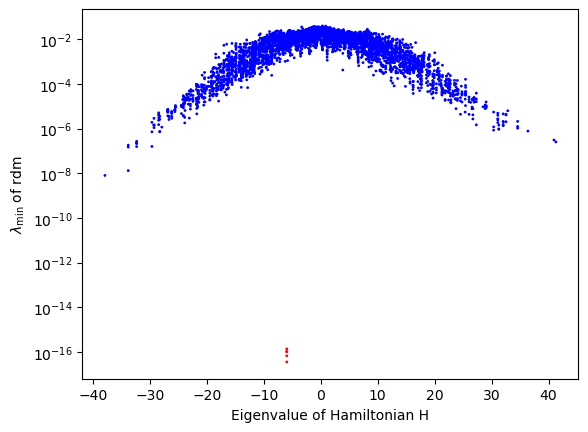

In [46]:
# Define the threshold
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [28]:
# Find indices of red points
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] that are smaller than 1e-16
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of eigenvalues smaller than 1e-16: {counts}')

Indices of red points: [1266, 1267, 1268, 1269, 1270]
0 1266
Eigenvalue: -6.000000000000003, rdm Minimum Eigenvalue: -5.068389397934375e-17
Eigenvector 1266: rdm rank: 11
1 1267
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -2.7795075765071667e-17
Eigenvector 1267: rdm rank: 11
2 1268
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -8.519229768198621e-17
Eigenvector 1268: rdm rank: 11
3 1269
Eigenvalue: -5.999999999999997, rdm Minimum Eigenvalue: -5.305424579531258e-17
Eigenvector 1269: rdm rank: 11
4 1270
Eigenvalue: -5.9999999999999964, rdm Minimum Eigenvalue: -4.475935646746779e-17
Eigenvector 1270: rdm rank: 11
Dot product between eigenvectors 1266 and 1266: 0.9999999999999998
Dot product between eigenvectors 1266 and 1267: -7.37257477290143e-17
Dot product between eigenvectors 1266 and 1268: 2.47198095326695e-17
Dot product between eigenvectors 1266 and 1269: 3.469446951953614e-17
Dot product between eigenvectors 1266 and 1270: -2.0816681711721685e-17
Dot product between eigenvectors 1267 a

In [ ]:
# 4/5 spins rdm - no qutip

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = partial_trace_qubit(density_matrix, keep_qubits, [2]*N)

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced)

100%|██████████| 4096/4096 [03:32<00:00, 19.26it/s]


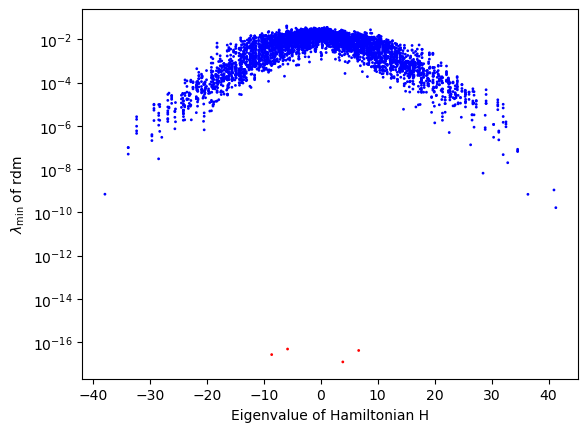

In [15]:
#no qutip

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [29]:
# Find indices of red points - no qutip
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

for i in range(len(red_indices_np)):
    for j in range(len(red_indices_np)):
        idx1, idx2 = red_indices_np[i], red_indices_np[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] that are smaller than 1e-16
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of eigenvalues smaller than 1e-16: {counts_np}')

Indices of red points: [984, 1297, 2585, 2921]
0 984
Eigenvalue: -8.644317875007733, rdm Minimum Eigenvalue: -2.664118740979248e-17
Eigenvector 984: rdm rank: 15
1 1297
Eigenvalue: -5.854318101014528, rdm Minimum Eigenvalue: -4.8230079862603074e-17
Eigenvector 1297: rdm rank: 15
2 2585
Eigenvalue: 3.8543181010145298, rdm Minimum Eigenvalue: 1.2214296990251463e-17
Eigenvector 2585: rdm rank: 15
3 2921
Eigenvalue: 6.644317875007728, rdm Minimum Eigenvalue: -4.138308426858821e-17
Eigenvector 2921: rdm rank: 15
Dot product between eigenvectors 984 and 984: 0.9999999999999998
Dot product between eigenvectors 984 and 1297: -2.688821387764051e-17
Dot product between eigenvectors 984 and 2585: 2.6020852139652106e-17
Dot product between eigenvectors 984 and 2921: 3.469446951953614e-18
Dot product between eigenvectors 1297 and 984: -2.688821387764051e-17
Dot product between eigenvectors 1297 and 1297: 0.9999999999999998
Dot product between eigenvectors 1297 and 2585: -1.0408340855860843e-17
Dot 

In [63]:
import torch
import numpy as np
from tqdm import tqdm

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")
    
    shape = arr.shape
    return len(shape) == 2 and shape[1] == 1

def ptrace_torch(Q, sel, dims):
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.
    """
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = sel.sort().values.tolist()
    
    qtrace = list(set(range(nd)) - set(sel))
    dkeep = [rd[i].item() for i in sel]
    dtrace = [rd[i].item() for i in qtrace]
    
    rd = rd.tolist()
    if isket_torch(Q):
        vmat = (Q
                .reshape(rd)
                .permute(sel + qtrace)
                .reshape(torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))))
        rhomat = vmat @ vmat.conj().T
    else:
        reshaped_Q = Q.reshape(rd + rd)
        permuted_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        traced_Q = permuted_Q.reshape(
            torch.prod(torch.tensor(dtrace)),
            torch.prod(torch.tensor(dtrace)),
            torch.prod(torch.tensor(dkeep)),
            torch.prod(torch.tensor(dkeep))
        )
        rhomat = traced_Q.diagonal(dim1=0, dim2=1).sum(dim=0)  # Fix: Correct trace computation
    
    return rhomat

# 4/5 spins rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.complex64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    # keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy())

  0%|          | 0/4096 [00:00<?, ?it/s]


RuntimeError: linalg.eigh: A must be batches of square matrices, but they are 16 by 256 matrices

In [ ]:
# 4/5 spins rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.complex64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    # keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = partial_trace_qubit_torch(density_matrix, keep_qubits, [2] * N)

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy())

100%|██████████| 4096/4096 [01:16<00:00, 53.70it/s]


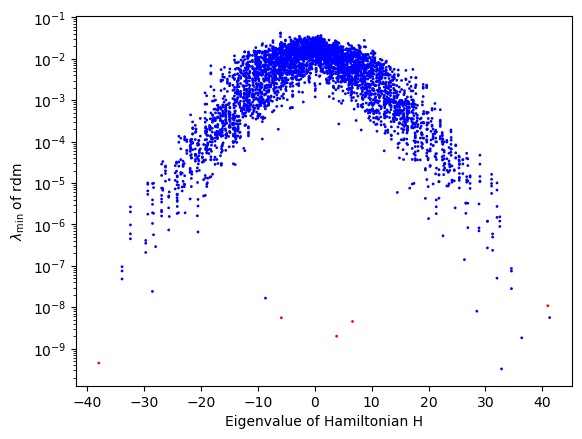

In [49]:
#torch

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [39]:
# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] that are smaller than 1e-16
counts_to = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of eigenvalues smaller than 1e-16: {counts_to}')

Indices of red points: [0, 1297, 2585, 2921, 4094]
0 0
Eigenvalue: -37.94564249857244, rdm Minimum Eigenvalue: -4.5195958087163035e-10
Eigenvector 0: rdm rank: 14
1 1297
Eigenvalue: -5.854318101014528, rdm Minimum Eigenvalue: -5.575720329886735e-09
Eigenvector 1297: rdm rank: 15
2 2585
Eigenvalue: 3.8543181010145298, rdm Minimum Eigenvalue: -2.000888343900442e-09
Eigenvector 2585: rdm rank: 15
3 2921
Eigenvalue: 6.644317875007728, rdm Minimum Eigenvalue: -4.540197551250458e-09
Eigenvector 2921: rdm rank: 15
4 4094
Eigenvalue: 40.95956434822085, rdm Minimum Eigenvalue: -1.0866770594475383e-08
Eigenvector 4094: rdm rank: 11
Dot product between eigenvectors 0 and 0: 1.0000000000000022
Dot product between eigenvectors 0 and 1297: -2.1771173850390265e-18
Dot product between eigenvectors 0 and 2585: -1.8195965351577418e-19
Dot product between eigenvectors 0 and 2921: -3.883981169147617e-20
Dot product between eigenvectors 0 and 4094: 1.017969519024971e-17
Dot product between eigenvectors 129

In [18]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices)) + 1j* np.random.rand(len(red_indices))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
max_scar = np.sum(eigenvectors[:, red_indices] * random_coeffs, axis=1)

# Define max mixed state from 5 scarred states
#max_scar = np.sum(eigenvectors[:, red_indices], axis=1)/np.sqrt(len(red_indices))

print(len(max_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices])

[0.52764686+0.35609209j 0.36943168+0.17426242j 0.11596246+0.07727372j
 0.16163342+0.03905551j 0.5504352 +0.27909127j]
coeffs norm 1.0
4096


In [19]:
max_scar = linear_combination_np(random_coeffs, red_eigenvectors)
max_scar_entropy = entanglement_entropy(max_scar, N // 2, N)
max_scar_entropy_qutip = entanglement_entropy_qutip(max_scar, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {max_scar_entropy}")
print(f"Entanglement entropy of random scar state (Qutip): {max_scar_entropy_qutip}")

Random scar coeffs [0.52764686+0.35609209j 0.36943168+0.17426242j 0.11596246+0.07727372j
 0.16163342+0.03905551j 0.5504352 +0.27909127j]
Entanglement entropy of random scar state: 4.746121112787138
Entanglement entropy of random scar state (Qutip): 4.746121112787149


In [20]:
# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
naive_entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in tqdm(range(eigenvectors.shape[1]))]
qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 4096/4096 [11:58<00:00,  5.70it/s]


Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248113
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Random scar entropy: 4.746121112787138


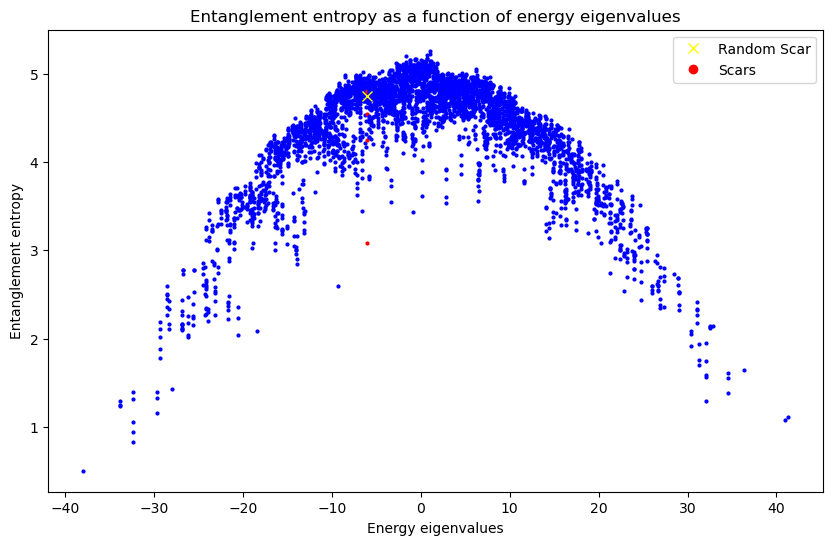

In [21]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Random scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), max_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304969
Index: 1267, Entropy: 3.085208378924823
Index: 1268, Entropy: 4.808932481473981
Index: 1269, Entropy: 4.254512053088176
Index: 1270, Entropy: 4.548550915890681
Random scar entropy: 4.746121112787149


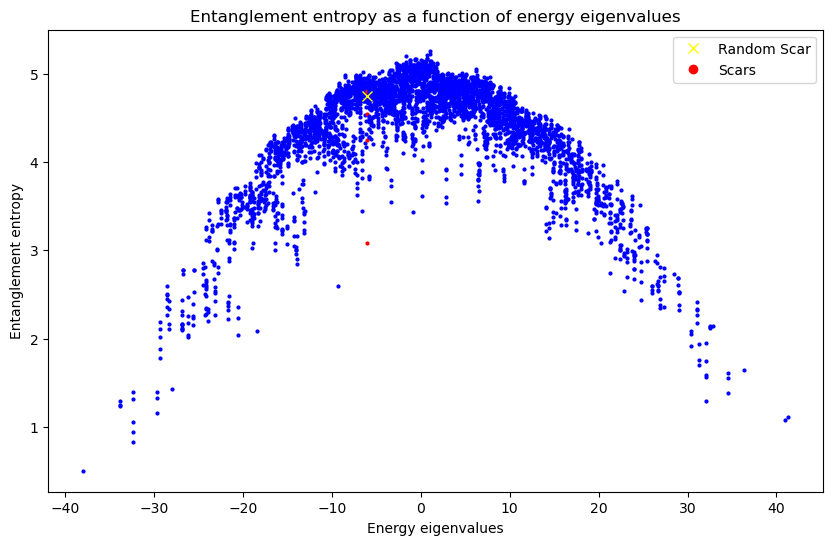

In [22]:
# Compute entanglement entropy for the max_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {max_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), max_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248113
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Maximum scar entropy: 4.746121112787138


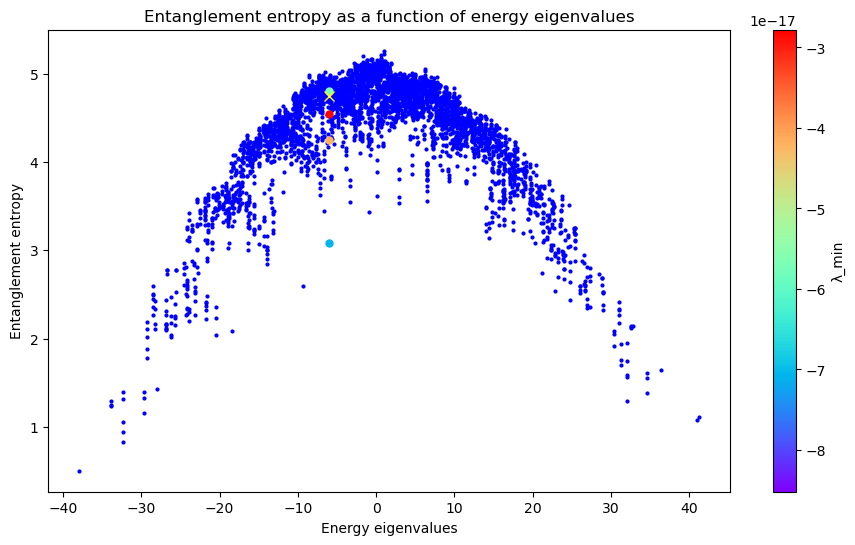

In [23]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Maximum scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), max_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label='λ_min')

ax.set_xlabel('Energy eigenvalues')
ax.set_ylabel('Entanglement entropy')
ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [24]:
#compute qutip bipartite ptrace before optimization, then convert to torch tensor

outer_products = []
partial_traces = []

red_eigenvectors = list(red_eigenvectors)
print(len(red_eigenvectors))

for i in range(len(red_eigenvectors)):
    for j in range(len(red_eigenvectors)):
        outer_product = np.outer(red_eigenvectors[i], red_eigenvectors[j].conj())
        outer_products.append(outer_product)

# Convert the list of outer products to a NumPy array
outer_products = np.array(outer_products)

print(len(outer_products))

# Compute the partial trace for each element in outer_products
for op in outer_products:
    density_matrix_qobj = Qobj(op, dims=[[2]*N, [2]*N])
    ptrace_op = ptrace(density_matrix_qobj, list(range(N // 2)))  # tracing out half system because I'm interested in bipartite entanglement entropy
    partial_traces.append(ptrace_op)

# Convert the partial traces from Qobj to PyTorch tensors
partial_traces_torch = [torch.tensor(pt.full(), dtype=torch.complex64) for pt in partial_traces]

# Print the partial traces
for idx, pt in enumerate(partial_traces):
    print(f"Partial trace of outer product {idx}:\n{pt}\n")

5
25
Partial trace of outer product 0:
Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.91605503e-26  4.32055154e-17  4.63845466e-18 ...  3.52330699e-18
   3.93055450e-19 -5.65855646e-29]
 [ 4.32055154e-17  2.94962353e-03 -1.06244160e-15 ...  3.54162615e-16
  -9.06154528e-16 -4.07556900e-19]
 [ 4.63845466e-18 -1.06244160e-15  1.56495270e-02 ... -1.18171322e-15
   1.47662418e-15  2.03225061e-18]
 ...
 [ 3.52330699e-18  3.54162615e-16 -1.18171322e-15 ...  1.56495270e-02
  -3.76691793e-16  9.27338683e-18]
 [ 3.93055450e-19 -9.06154528e-16  1.47662418e-15 ... -3.76691793e-16
   2.94962353e-03  8.49800719e-18]
 [-5.65855646e-29 -4.07556900e-19  2.03225061e-18 ...  9.27338683e-18
   8.49800719e-18  3.53114949e-27]]

Partial trace of outer product 1:
Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.07422039e-27 -9.15222882e-

In [25]:
print(len(partial_traces_torch))
print(type(partial_traces_torch[0]))

25
<class 'torch.Tensor'>


In [26]:
coeffs = np.array([0, 1, 2, 3, 4])

# Compute the numpy array of out_coeffs which is the product of all possible combinations of c_i^* times c_j
out_coeffs = np.zeros((len(coeffs), len(coeffs)), dtype=np.complex64)
for i in range(len(coeffs)):
    for j in range(len(coeffs)):
        out_coeffs[i, j] = np.conj(coeffs[i]) * coeffs[j]

print(out_coeffs.shape)

(5, 5)


In [27]:
class EntropyFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, rho_out):
        rho_out_np = rho_out.detach().cpu().numpy()
        entropy = entanglement_entropy_np_ptrace(rho_out_np)
        #rho_out_qobj = Qobj(rho_out_np, dims=[[2]*(N//2), [2]*(N//2)])
        #entropy = entropy(rho_out_qobj, base=2)
        #entropy = entropy.numpy()
        ctx.save_for_backward(rho_out)
        return torch.tensor(entropy, dtype=torch.float32)

    @staticmethod
    def backward(ctx, grad_output):
        rho_out, = ctx.saved_tensors
        grad = torch.zeros_like(rho_out)
        # Compute the gradient manually or using finite differences
        # This is a placeholder for the actual gradient computation
        return grad * grad_output

#Convert random_coeffs to PyTorch tensors
params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)
print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute rho_A for the red points
rho_out = linear_combination_outer(torch.complex(params_real, params_imag), partial_traces_torch)

print(len(rho_out))

# Compute entanglement entropy using the custom autograd function
entropy_torch = EntropyFunction.apply(rho_out)
print(f'Initial Entropy: {entropy_torch.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute rho_A for the red points
    rho_out = linear_combination_outer(coeffs, partial_traces_torch)

    # Compute entanglement entropy using the custom autograd function
    entropy_torch = EntropyFunction.apply(rho_out)
    
    # Backpropagation
    entropy_torch.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy_torch.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy_torch.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history = np.array(coeffs_history)
for i in range(coeffs_history.shape[1]):
    plt.plot(coeffs_history[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Initial coeffs, real tensor([0.5276, 0.3694, 0.1160, 0.1616, 0.5504], requires_grad=True)
Initial coeffs imag tensor([0.3561, 0.1743, 0.0773, 0.0391, 0.2791], requires_grad=True)
Initial coeffs, real tensor([0.5276, 0.3694, 0.1160, 0.1616, 0.5504], requires_grad=True)
Initial coeffs imag tensor([0.3561, 0.1743, 0.0773, 0.0391, 0.2791], requires_grad=True)
64
Initial Entropy: 5.987332820892334


C:\Users\camipolv\AppData\Local\Temp\ipykernel_21132\1120668167.py:326: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)
C:\Users\camipolv\AppData\Local\Temp\ipykernel_21132\1120668167.py:326: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#Convert random_coeffs to PyTorch tensors
params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)
print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute rho_A for the red points
rho_out = linear_combination_outer(torch.complex(params_real, params_imag), partial_traces_torch)

print(len(rho_out))

# Compute entanglement entropy using the custom autograd function
entropy_torch = entanglement_entropy_torch_ptrace(rho_out)
print(f'Initial Entropy: {entropy_torch.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute rho_A for the red points
    rho_out = linear_combination_outer(coeffs, partial_traces_torch)

    # Compute entanglement entropy using the custom autograd function
    entropy_torch = entanglement_entropy_torch_ptrace(rho_out)
    
    # Backpropagation
    entropy_torch.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy_torch.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy_torch.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history = np.array(coeffs_history)
for i in range(coeffs_history.shape[1]):
    plt.plot(coeffs_history[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Initial coeffs, real tensor([0.3379, 0.4219, 0.1892, 0.3670, 0.4214], requires_grad=True)
Initial coeffs imag tensor([0.0467, 0.2841, 0.1458, 0.4429, 0.2439], requires_grad=True)
Initial coeffs, real tensor([0.3379, 0.4219, 0.1892, 0.3670, 0.4214], requires_grad=True)
Initial coeffs imag tensor([0.0467, 0.2841, 0.1458, 0.4429, 0.2439], requires_grad=True)
64
Initial Entropy: 4.698172569274902


C:\Users\camipolv\AppData\Local\Temp\ipykernel_1216\1120668167.py:326: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

: 

Initial coeffs, real tensor([0.3379, 0.4219, 0.1892, 0.3670, 0.4214], requires_grad=True)
Initial coeffs imag tensor([0.0467, 0.2841, 0.1458, 0.4429, 0.2439], requires_grad=True)
Initial Entropy: 4.731538772583008
Coeffs norm: 1.0
Entropy: 4.731538772583008
Coeffs: [0.33786562+0.04668679j 0.42186213+0.2841441j  0.18920049+0.14579456j
 0.36699438+0.44294894j 0.4213713 +0.2438572j ]
Coeffs norm: 0.9999999
Entropy: 4.707465171813965
Coeffs: [0.32788712+0.0366892j  0.43189043+0.27416208j 0.19921356+0.15580478j
 0.3570178 +0.43297735j 0.43139958+0.25387385j]
Coeffs norm: 1.0000001
Entropy: 4.682353973388672
Coeffs: [0.31755185+0.02723973j 0.44139874+0.26424834j 0.20900863+0.16564393j
 0.34666377+0.4225317j  0.4409524 +0.26360676j]
Coeffs norm: 1.0
Entropy: 4.6563286781311035
Coeffs: [0.3069283 +0.01996274j 0.45023137+0.25422385j 0.21860634+0.17532489j
 0.33599675+0.41169557j 0.45007998+0.27307832j]
Coeffs norm: 0.99999994
Entropy: 4.629301071166992
Coeffs: [0.29616857+0.01727406j 0.45768294

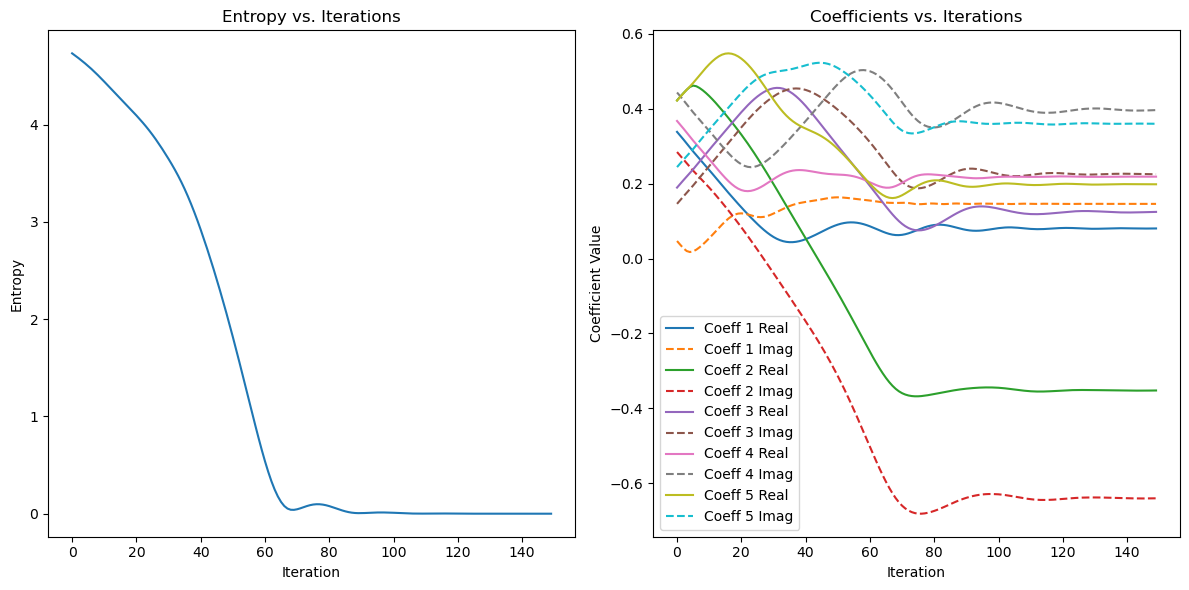

In [ ]:
# find entropy min coeffs

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history = np.array(coeffs_history)
for i in range(coeffs_history.shape[1]):
    plt.plot(coeffs_history[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Initial coeffs, real tensor([0.3379, 0.4219, 0.1892, 0.3670, 0.4214], requires_grad=True)
Initial coeffs imag tensor([0.0467, 0.2841, 0.1458, 0.4429, 0.2439], requires_grad=True)
Initial Entropy: 4.731538772583008
Coeffs norm: 1.0
Entropy: 4.731538772583008
Coeffs: [0.33786562+0.04668679j 0.42186213+0.2841441j  0.18920049+0.14579456j
 0.36699438+0.44294894j 0.4213713 +0.2438572j ]
Coeffs norm: 1.0
Entropy: 4.754352569580078
Coeffs: [0.34749556+0.05662648j 0.411424  +0.2938312j  0.17900985+0.1356501j
 0.37659335+0.45246708j 0.41093373+0.23360842j]
Coeffs norm: 1.0
Entropy: 4.775679588317871
Coeffs: [0.3569949 +0.06649886j 0.40093696+0.30127865j 0.16879742+0.12549593j
 0.38590556+0.46179396j 0.40040642+0.22331461j]
Coeffs norm: 0.99999994
Entropy: 4.795360565185547
Coeffs: [0.36622337+0.07633124j 0.39143416+0.30655795j 0.15852787+0.11531278j
 0.39454535+0.47071502j 0.3896837 +0.212921j  ]
Coeffs norm: 1.0
Entropy: 4.813356399536133
Coeffs: [0.3746412 +0.08602075j 0.38568786+0.3104588j  0

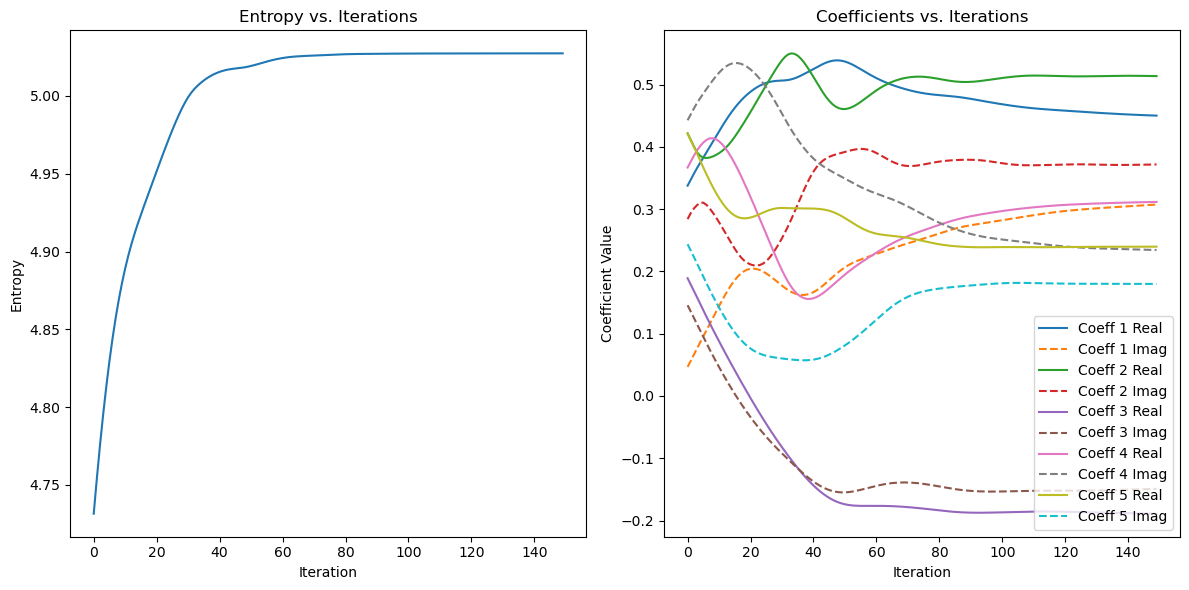

In [ ]:
# now find entropy max coeffs

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248113
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Maximum scar entropy: 2.708104235136907e-05


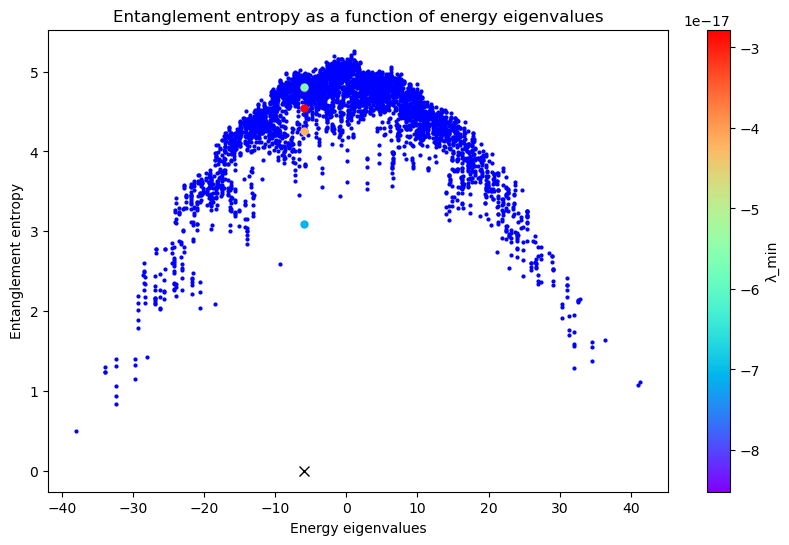

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for all eigenstates in the full Hilbert space
#subsystem_size = N // 2
#naive_entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, subsystem_size, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Maximum scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label='λ_min')

ax.set_xlabel('Energy eigenvalues')
ax.set_ylabel('Entanglement entropy')
ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [ ]:
#now look at structure with these optimal coeffs corresp to min entropy

print(len(max_scar))

#Count the number of zero entries
num_zeros = np.count_nonzero((max_scar.real < 1e-16) & (max_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')


rho_scar = np.dot(max_scar, max_scar.conj().T)
print("Rank of rho scar:", np.linalg.matrix_rank(rho_scar))

# Reshape psi into a 2^subsystem_size x 2^environment_size matrix
psi_matrix = max_scar.reshape((2**(N // 2), 2**(N // 2)))

# Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B

print(np.trace(rho_A))
print(np.trace(rho_A @ rho_A))
print(np.trace(np.dot(rho_A, rho_A)))

# Check if rho_A is Hermitian
is_hermitian = np.allclose(rho_A, rho_A.conj().T)
print(f'Is rho_A Hermitian? {is_hermitian}')

4096
Number of zero entries: 2370
Rank of rho scar: 1
(1.0000000598268126+0j)
(0.9999980241983217+0j)
(0.9999980241983217+0j)
Is rho_A Hermitian? True


In [ ]:
#find a 4/5 spins charge commuting with the rdm.